In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

#### Get the CESM tseries files for nutrients and other vars

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'

In [3]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'

In [4]:
path

'/glade/scratch/kristenk/archive/g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1/ocn/proc/tseries/month_1'

In [5]:
variables = ['Fe','NO3', 'PO4','SiO3','DIC','TEMP',
             'coccoC','diatC','spC']

In [6]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)

    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1
Fe
NO3
PO4
SiO3
DIC
TEMP
coccoC
diatC
spC
CPU times: user 3.56 s, sys: 208 ms, total: 3.76 s
Wall time: 6.14 s


#### Get grid

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

### get just the last 20 years of simulation (1999 to 2018)

In [8]:
ds = ds.isel(time=slice(492,732))

### Make a climatology for that

In [9]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [10]:
ds_clim = ds.groupby('time.month').mean('time')

In [11]:
variables

['Fe', 'NO3', 'PO4', 'SiO3', 'DIC', 'TEMP', 'coccoC', 'diatC', 'spC']

In [12]:
ds_clim_100m = xr.Dataset()

for var in ['Fe', 'NO3', 'PO4', 'SiO3', 'DIC', 'TEMP']:
    ds_clim_100m[var] = ds_clim[var].isel(z_t=slice(0,10)).mean(dim='z_t')
    
for var in ['coccoC', 'diatC', 'spC']:
    ds_clim_100m[var] = ds_clim[var].isel(z_t_150m=slice(0,10)).mean(dim='z_t_150m')

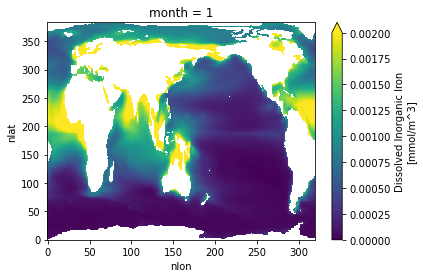

In [13]:
ds_clim_100m.Fe.isel(month=0).plot(vmin=0,vmax=0.002)

### Set up mask for whole 150W transect

#### 150W transect line: mean 43°S to 45°S, mean 154°W to 156°W

In [14]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

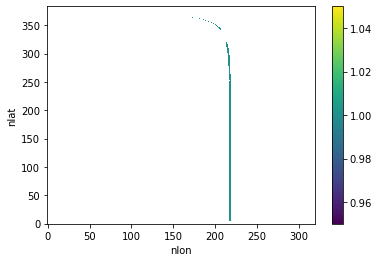

In [15]:
mask_transect150W = ones.where(lons_norm>-156).where(lons_norm<-154)
mask_transect150W.plot()

In [16]:
# mask_bloomreg = ones.where(lons_norm>-156).where(lons_norm<-154)
# mask_bloomreg.plot()

In [17]:
ds_clim_100m

<xarray.Dataset>
Dimensions:  (month: 12, nlat: 384, nlon: 320)
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    Fe       (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    NO3      (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    PO4      (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    SiO3     (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    DIC      (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TEMP     (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    coccoC   (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    diatC    (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    spC      (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

In [28]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='256 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [29]:
cluster, client = get_ClusterClient()
cluster.scale(8) 
client

Client Scheduler: tcp://10.12.206.59:35890 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [30]:
ts_clim_transect = xr.Dataset()

transect_vars = variables + ['TLAT']

for v in transect_vars:
    
    ts_clim_transect[v] = esmlab.statistics.weighted_mean(ds_clim_100m[v].where(mask_transect150W==1), weights=area, dim=['nlon'])
    ts_clim_transect[v].attrs = ds[v].attrs

ts_clim_transect.load()

<xarray.Dataset>
Dimensions:  (month: 12, nlat: 384)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat
Data variables:
    Fe       (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    NO3      (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    PO4      (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    SiO3     (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    DIC      (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    TEMP     (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    coccoC   (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    diatC    (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    spC      (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT     (nlat) float64 nan nan nan nan nan -76.55 ... nan nan nan nan nan

In [31]:
ts_clim_transect_depth = xr.Dataset()

transect_vars = variables + ['TLAT']

for v in transect_vars:
    
    ts_clim_transect_depth[v] = esmlab.statistics.weighted_mean(ds_clim[v].where(mask_transect150W==1), weights=area, dim=['nlon'])
    ts_clim_transect_depth[v].attrs = ds[v].attrs

ts_clim_transect_depth.load()

<xarray.Dataset>
Dimensions:   (month: 12, nlat: 384, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat
Data variables:
    Fe        (month, z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    NO3       (month, z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    PO4       (month, z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3      (month, z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    DIC       (month, z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    TEMP      (month, z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    coccoC    (month, z_t_150m, nlat) float64 nan nan nan nan ... nan nan nan
    diatC     (month, z_t_150m, nlat) float64 nan nan nan nan ... nan nan nan
    spC       (month, z_t_150m, nlat) float64 nan nan nan nan ... nan nan nan
    TLAT      (nlat) float64 nan nan nan nan nan -76.55 ... nan nan nan nan nan

[Text(0, 0.5, 'NO3/SiO3 (mmol m$^{-3}$)'), Text(0.5, 0, 'latitude')]

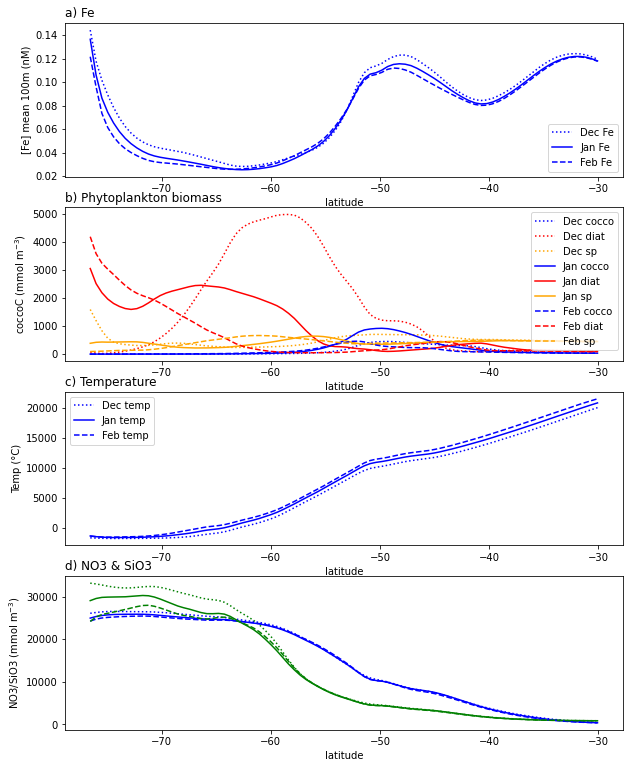

In [32]:
fig = plt.figure(figsize=(10,13))

ax = fig.add_subplot(4,1,1)
ax.set_title('a) Fe', loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.Fe.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='blue',label='Dec Fe',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.Fe.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='blue',label='Jan Fe')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.Fe.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='blue',label='Feb Fe',linestyle='--')
ax.set(ylabel='[Fe] mean 100m (nM)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(4,1,2)
ax.set_title('b) Phytoplankton biomass',loc='left')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.coccoC.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='blue',label='Dec cocco',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.diatC.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='red',label='Dec diat',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.spC.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='orange',label='Dec sp',linestyle=':')


ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.coccoC.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='blue',label='Jan cocco')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.diatC.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='red',label='Jan diat')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.spC.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='orange',label='Jan sp')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.coccoC.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='blue',label='Feb cocco',linestyle='--')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.diatC.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='red',label='Feb diat',linestyle='--')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.spC.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='orange',label='Feb sp',linestyle='--')


ax.set(ylabel='coccoC (mmol m$^{-3}$)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(4,1,3)
ax.set_title('c) Temperature ',loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.TEMP.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='blue', label='Dec temp',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.TEMP.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='blue', label='Jan temp')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.TEMP.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='blue', label='Feb temp',linestyle='--')
ax.set(ylabel='Temp (°C)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(4,1,4)
ax.set_title('d) NO3 & SiO3',loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.NO3.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='blue', label='Dec NO3',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.SiO3.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='green',label='Dec SiO3',linestyle=':')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.NO3.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='blue', label='Jan NO3')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.SiO3.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='green',label='Jan SiO3')
        
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.NO3.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='blue', label='Feb NO3',linestyle='--')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.SiO3.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='green',label='Feb SiO3',linestyle='--')
ax.set(ylabel='NO3/SiO3 (mmol m$^{-3}$)',xlabel='latitude')


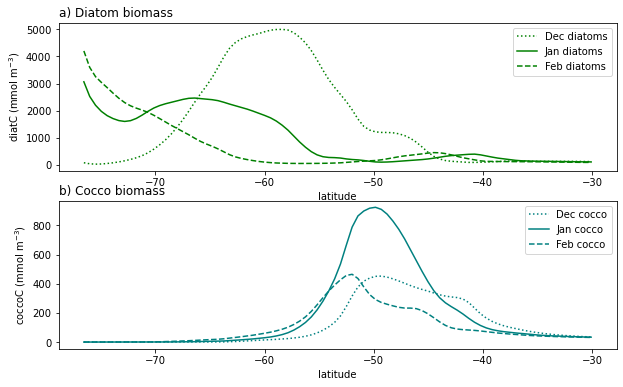

In [33]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(2,1,1)
ax.set_title('a) Diatom biomass', loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.diatC.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='green',label='Dec diatoms',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.diatC.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='green',label='Jan diatoms')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.diatC.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='green',label='Feb diatoms',linestyle='--')
ax.set(ylabel='diatC (mmol m$^{-3}$)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.set_title('b) Cocco biomass',loc='left')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.coccoC.isel(month=11).where(ts_clim_transect.TLAT<-30)*1000,color='teal',label='Dec cocco',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.coccoC.isel(month=0).where(ts_clim_transect.TLAT<-30)*1000,color='teal',label='Jan cocco')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30),
        ts_clim_transect.coccoC.isel(month=1).where(ts_clim_transect.TLAT<-30)*1000,color='teal',label='Feb cocco',linestyle='--')

ax.set(ylabel='coccoC (mmol m$^{-3}$)',xlabel='latitude')
ax.legend()




### figure out indices for latitude segment that compares with Hilde's plots

In [34]:
ts_clim_transect_depth.TLAT[62].values

array(-46.09851377)

In [35]:
ts_clim_transect_depth.TLAT[68].values

array(-42.89307096)

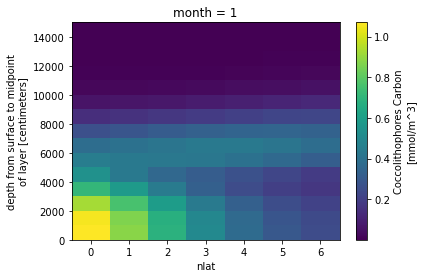

In [44]:
bloom_reg = ts_clim_transect_depth.isel(month=0)
bloom_reg['coccoC'][:,62:69].plot()

In [43]:
bloom_reg

<xarray.Dataset>
Dimensions:   (nlat: 384, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    month     int64 1
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat
Data variables:
    Fe        (z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    NO3       (z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    PO4       (z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    SiO3      (z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    DIC       (z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    TEMP      (z_t, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    coccoC    (z_t_150m, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    diatC     (z_t_150m, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    spC       (z_t_150m, nlat) float64 nan nan nan nan nan ... nan nan nan nan
    TLAT      (nlat) float64 nan nan nan nan nan -76.55 ... nan nan nan nan nan

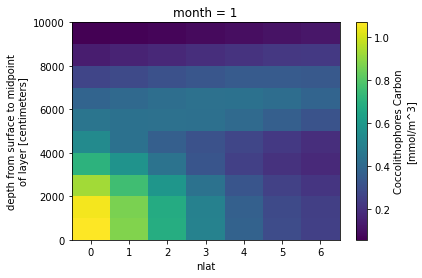

In [45]:
bloom_reg = ts_clim_transect_depth.isel(month=0)
bloom_reg['coccoC'][0:10,62:69].plot()

In [40]:
latitudes = bloom_reg.TLAT[62:69].values

In [41]:
depths = bloom_reg.z_t.values[0:10]*0.01

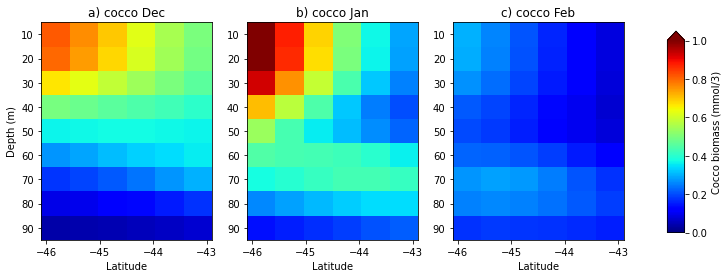

In [61]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) cocco Dec')
bloom_reg = ts_clim_transect_depth.isel(month=11)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['coccoC'][0:10,62:69],
                 vmin=0,vmax=1,
                 cmap='jet')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()

ax = fig.add_subplot(1,3,2)
ax.set_title('b) cocco Jan')
bloom_reg = ts_clim_transect_depth.isel(month=0)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['coccoC'][0:10,62:69],
                 vmin=0,vmax=1,
                 cmap='jet')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()

ax = fig.add_subplot(1,3,3)
ax.set_title('c) cocco Feb')
bloom_reg = ts_clim_transect_depth.isel(month=1)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['coccoC'][0:10,62:69],
                 vmin=0,vmax=1,
                 cmap='jet')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Cocco biomass (mmol/3)', extend='max')

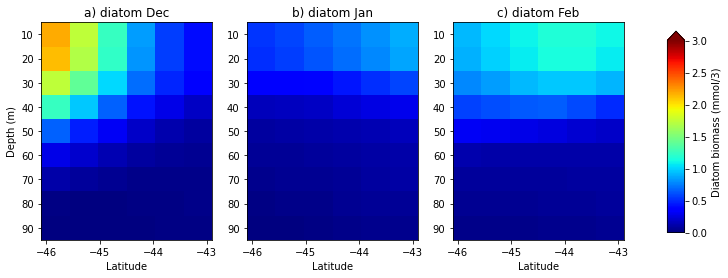

In [60]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) diatom Dec')
bloom_reg = ts_clim_transect_depth.isel(month=11)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['diatC'][0:10,62:69],
                 vmin=0,vmax=3,
                 cmap='jet')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()

ax = fig.add_subplot(1,3,2)
ax.set_title('b) diatom Jan')
bloom_reg = ts_clim_transect_depth.isel(month=0)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['diatC'][0:10,62:69],
                 vmin=0,vmax=3,
                 cmap='jet')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()

ax = fig.add_subplot(1,3,3)
ax.set_title('c) diatom Feb')
bloom_reg = ts_clim_transect_depth.isel(month=1)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['diatC'][0:10,62:69],
                 vmin=0,vmax=3,
                 cmap='jet')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Diatom biomass (mmol/3)', extend='max')

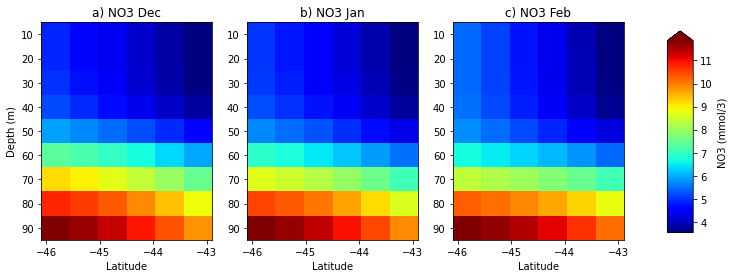

In [59]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) NO3 Dec')
bloom_reg = ts_clim_transect_depth.isel(month=11)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['NO3'][0:10,62:69],
                 #vmin=0,vmax=1,
                 cmap='jet')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()


ax = fig.add_subplot(1,3,2)
ax.set_title('b) NO3 Jan')
bloom_reg = ts_clim_transect_depth.isel(month=0)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['NO3'][0:10,62:69],
                 #vmin=0,vmax=1,
                 cmap='jet')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()

ax = fig.add_subplot(1,3,3)
ax.set_title('c) NO3 Feb')
bloom_reg = ts_clim_transect_depth.isel(month=1)
pc=ax.pcolormesh(latitudes, depths, bloom_reg['NO3'][0:10,62:69],
                 #vmin=0,vmax=1,
                 cmap='jet')
ax.set_xlabel('Latitude')
plt.gca().invert_yaxis()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='NO3 (mmol/3)', extend='max')